In [90]:
!pip install tensorflow==2.15.0 tensorflow-gpu==2.15.0 opencv-python matplotlib 

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.15.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.15.0


In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [94]:
# # Make the directories
# # os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [85]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [4]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\7740ba3a-d622-11ee-8056-dc215ca24c6f.jpg'

In [104]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

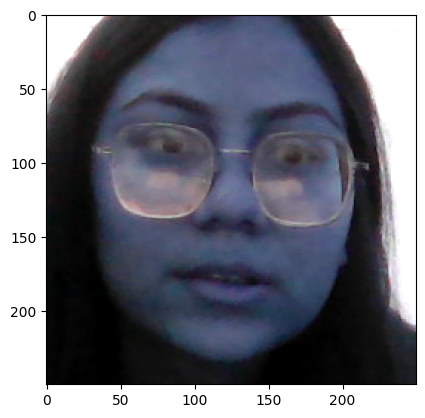

In [105]:
plt.imshow(frame[:250,:250, :])

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(100)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(100)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(100)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\817a086a-d60f-11ee-bbf3-dc215ca24c6f.jpg'


In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\817a086a-d60f-11ee-bbf3-dc215ca24c6f.jpg')

In [12]:
img.numpy().max() 

1.0

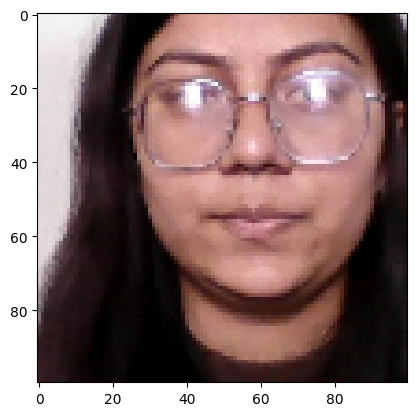

In [112]:
plt.imshow(img)

In [113]:
# dataset.map(preprocess)

In [114]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
example = samples.next()

In [16]:
example

(b'data\\anchor\\02f8f3bf-d60f-11ee-8b54-dc215ca24c6f.jpg',
 b'data\\positive\\35cb8325-d60e-11ee-a506-dc215ca24c6f.jpg',
 1.0)

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*example)

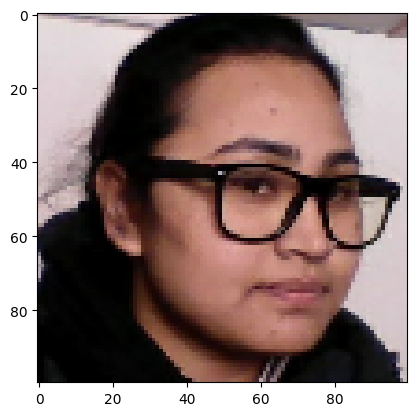

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
def make_embedding(): 
    model=Sequential()
    model.add(Input(shape=(100,100,3), name='input_image'))
    model.add(Conv2D(64, (5,5), activation='relu',padding='same'))
    model.add(MaxPooling2D( pool_size=(2,2), padding='same'))
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPooling2D( pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5,5), activation='relu',padding='same'))
    model.add(MaxPooling2D( pool_size=(2,2), padding='same'))
    model.add(Conv2D(128, (5,5), activation='relu',padding='same'))
    model.add(MaxPooling2D( pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(5, activation='softmax'))
    return model

In [128]:
# def make_embedding(): 
#     inp = Input(shape=(100,100,3), name='input_image')
    
#     # First block
#     c1 = Conv2D(64, (10,10), activation='relu')(inp)
#     m1 = MaxPooling2D(pool_size= (2,2), padding='same')(c1)
    
#     # Second block
#     c2 = Conv2D(128, (7,7), activation='relu')(m1)
#     m2 = MaxPooling2D(pool_size=(2,2), padding='same')(c2)
    
#     # Third block 
#     c3 = Conv2D(128, (4,4), activation='relu')(m2)
#     m3 = MaxPooling2D(pool_size=(2,2), padding='same')(c3)
    
#     # Final embedding block
#     c4 = Conv2D(256, (4,4), activation='relu')(m3)
#     f1 = Flatten()(c4)
#     d1 = Dense(4096, activation='sigmoid')(f1)
    
    
#     return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 23, 23, 64)        256       
 Normalization)                                                  
                                                        

In [27]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [133]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [29]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [30]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [31]:
siamese_layer = L1Dist()

In [32]:
distances = siamese_layer(inp_embedding, val_embedding)

In [33]:
classifier = Dense(1, activation='sigmoid')(distances)

In [34]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>

In [35]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [36]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential (Sequential)     (None, 5)                    2200133   ['input_img[0][0]',           
                                                                     'validation_img[0][0]']      
                                                                                     

In [37]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential (Sequential)     (None, 5)                    2200133   ['input_img[0][0]',           
                                                                     'validation_img[0][0]']      
                                                                                     

In [43]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [44]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [46]:
test_batch = train_data.as_numpy_iterator()

In [47]:
batch_1 = test_batch.next()

In [48]:
X = batch_1[:2]

In [49]:
y = batch_1[2]

In [50]:
y

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [153]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.ke

In [51]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [155]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [198]:
EPOCHS = 100

In [199]:
train(train_data, EPOCHS)


 Epoch 1/100
9/9 [==============================] - 4s 418ms/step

 Epoch 2/100
9/9 [==============================] - 4s 407ms/step

 Epoch 3/100
9/9 [==============================] - 4s 399ms/step

 Epoch 4/100
9/9 [==============================] - 4s 387ms/step

 Epoch 5/100
9/9 [==============================] - 4s 407ms/step

 Epoch 6/100
9/9 [==============================] - 4s 411ms/step

 Epoch 7/100
9/9 [==============================] - 4s 414ms/step

 Epoch 8/100
9/9 [==============================] - 5s 532ms/step

 Epoch 9/100
9/9 [==============================] - 5s 520ms/step

 Epoch 10/100
9/9 [==============================] - 5s 522ms/step

 Epoch 11/100
9/9 [==============================] - 5s 546ms/step

 Epoch 12/100
9/9 [==============================] - 5s 523ms/step

 Epoch 13/100
9/9 [==============================] - 5s 546ms/step

 Epoch 14/100
9/9 [==============================] - 5s 520ms/step

 Epoch 15/100
9/9 [==============================] - 5s 

In [52]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [53]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [54]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[0.4999592 ],
       [0.4999526 ],
       [0.49994138],
       [0.49995878],
       [0.49997294],
       [0.49996546],
       [0.4999821 ],
       [0.49995854],
       [0.49996638],
       [0.49997765],
       [0.49989283],
       [0.5000193 ],
       [0.5000153 ],
       [0.49988407],
       [0.49993905],
       [0.50001985]], dtype=float32)

In [203]:
# Post processing the results 
[1 if prediction > 0.7 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]

In [204]:
y_true

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [205]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [206]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

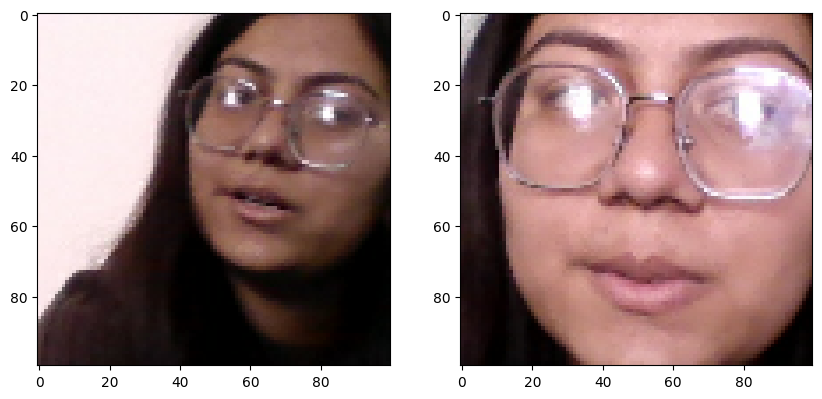

In [241]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[7])

# Set second subplo1
plt.subplot(1,2,2)
plt.imshow(test_val[7])

# Renders cleanly
plt.show()

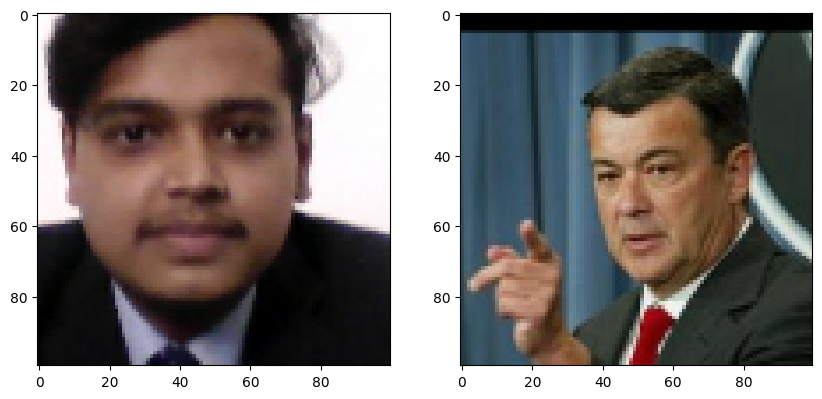

In [243]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [209]:
# Save weights
siamese_model.save('siamesemodels.h5')

In [55]:
L1Dist

__main__.L1Dist

In [56]:

# Reload model 
model = tf.keras.models.load_model('siamesemodels.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'categorical_Crossentropy':tf.losses.BinaryCrossentropy})

In [57]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 894ms/step


array([[0.6365075 ],
       [0.39158377],
       [0.41236785],
       [0.4392149 ],
       [0.763187  ],
       [0.46600378],
       [0.3936072 ],
       [0.19139421],
       [0.56163865],
       [0.51056165],
       [0.36925885],
       [0.5734655 ],
       [0.51698875],
       [0.19499592],
       [0.49990386],
       [0.55381894]], dtype=float32)

In [217]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential_6 (Sequential)   (None, 5)                    2200133   ['input_img[0][0]',           
                                                                     'validation_img[0][0]']      
                                                                                     

In [58]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0daadf4e-d60f-11ee-b475-dc215ca24c6f - Copy.jpg',
 '0db6be13-d60f-11ee-8be3-dc215ca24c6f - Copy.jpg',
 '0dbe3227-d60f-11ee-81de-dc215ca24c6f - Copy.jpg',
 '0ddfeaed-d60f-11ee-88ae-dc215ca24c6f - Copy.jpg',
 '0de75316-d60f-11ee-b533-dc215ca24c6f - Copy.jpg',
 '0e7f5678-d60f-11ee-a10f-dc215ca24c6f - Copy.jpg',
 '101a5839-d60f-11ee-863b-dc215ca24c6f - Copy.jpg',
 '10ab5c7e-d60f-11ee-8be9-dc215ca24c6f - Copy.jpg',
 '227b533e-d60f-11ee-a793-dc215ca24c6f - Copy.jpg',
 '22c67d09-d60f-11ee-8920-dc215ca24c6f - Copy.jpg',
 '232e3d1f-d60f-11ee-be47-dc215ca24c6f - Copy.jpg',
 '236a90c1-d60f-11ee-9ad4-dc215ca24c6f - Copy.jpg',
 '23aaa6a3-d60f-11ee-bff2-dc215ca24c6f - Copy.jpg',
 '25fb94c2-d60f-11ee-9a34-dc215ca24c6f - Copy.jpg',
 '26e666e2-d60f-11ee-9f97-dc215ca24c6f - Copy.jpg',
 '274dc2e7-d60f-11ee-8046-dc215ca24c6f - Copy.jpg',
 '27c5c6ed-d60f-11ee-b550-dc215ca24c6f - Copy.jpg',
 '29f98452-d60f-11ee-a5c1-dc215ca24c6f - Copy.jpg',
 '2a013a31-d60f-11ee-9704-dc215ca24c6f - Copy.jpg',
 '2a6e1f0c-d

In [59]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [60]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0daadf4e-d60f-11ee-b475-dc215ca24c6f - Copy.jpg
application_data\verification_images\0db6be13-d60f-11ee-8be3-dc215ca24c6f - Copy.jpg
application_data\verification_images\0dbe3227-d60f-11ee-81de-dc215ca24c6f - Copy.jpg
application_data\verification_images\0ddfeaed-d60f-11ee-88ae-dc215ca24c6f - Copy.jpg
application_data\verification_images\0de75316-d60f-11ee-b533-dc215ca24c6f - Copy.jpg
application_data\verification_images\0e7f5678-d60f-11ee-a10f-dc215ca24c6f - Copy.jpg
application_data\verification_images\101a5839-d60f-11ee-863b-dc215ca24c6f - Copy.jpg
application_data\verification_images\10ab5c7e-d60f-11ee-8be9-dc215ca24c6f - Copy.jpg
application_data\verification_images\227b533e-d60f-11ee-a793-dc215ca24c6f - Copy.jpg
application_data\verification_images\22c67d09-d60f-11ee-8920-dc215ca24c6f - Copy.jpg
application_data\verification_images\232e3d1f-d60f-11ee-be47-dc215ca24c6f - Copy.jpg
application_data\verification_images\236a90c1-d60f-11ee-9ad4-dc21

In [61]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [62]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]
    
#     cv2.imshow('Verification', frame)
    
#     # Verification trigger
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         # Save input image to application_data/input_image folder 
#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         # Run verification
#         results, verified = verify(model, 0.9, 0.7)
#         print(verified)
    
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [63]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 53ms/step
False
1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 40ms/step
False
1/1 [==============================] - 0s 44ms/step
False
